In [1]:
from __future__ import print_function
from numpy import nan_to_num, array, empty_like, empty, vstack, concatenate, linspace, tile
import numpy as np
from scipy.signal import filtfilt, butter, buttord
import matplotlib.pyplot as plt
from pyriemann.estimation import Covariances
import pickle
import gzip
import os
import importlib
import sys
from pyriemann.utils import distance
from pyriemann.utils import mean
from collections import defaultdict

In [2]:
from pyriemann import classification
from sklearn.model_selection import cross_val_score

In [3]:
%matplotlib inline

# Covariance matrices: Matlab processed versus Python processed

## Building extended covariance matrices for EEG-based BCI

### Loading EEG data

The data are freely available from [GitHub](https://github.com/sylvchev/dataset-ssvep-exoskeleton/). The stimulation onsets are indicated in `event_pos` and the stimulation of `event_type` are coded as follow: 33024, 33025, 33026 and 33027 denote respectively the resting class, the 13 Hz, the 21 Hz and the 17 Hz stimulations. 

In [4]:
path_data = '../data/dataset-ssvep-exoskeleton/'

Evaluation will be done on session 1 of subject 12

In [5]:
subject_test = 7
session = 0
sample_rate = 256
path_subject = path_data+'subject{0:0>2}/'.format(subject_test)

Get subject data

In [6]:
def get_pickle_data(subject, path='../data/dataset-ssvep-exoskeleton/'):  
    path_subject = path_data+'subject{0:0>2}/'.format(subject)
    raw_signal = []
    event_pos = []
    event_type = []
    sample_rate = 256
    classes = ['Resting', '13Hz', '21Hz', '17Hz']
    channels = array(['Oz','O1','O2','PO3','POz','PO7','PO8','PO4'])
    for fn in os.listdir(path_subject):
        if fn.endswith('.pz'):
            with gzip.open(path_subject+fn, 'rb') as f:
                o = pickle.load(f, encoding='latin1')
            raw_signal.append(o['raw_signal'].T)
            event_pos.append(o['event_pos'].reshape((o['event_pos'].shape[0])))
            event_type.append(o['event_type'].reshape((o['event_type'].shape[0])))
#     nb_sess = len(raw_signal)
#     print('\t read {} sessions from subject {}'.format(nb_sess, subject))
    return (raw_signal, event_type, event_pos)

In [7]:
raw_signal, event_type, event_pos = get_pickle_data(subject=subject_test, path='../data/dataset-ssvep-exoskeleton/')

In [8]:
classes = ['Resting', '13Hz', '21Hz', '17Hz']
channels = array(['Oz','O1','O2','PO3','POz','PO7','PO8','PO4'])

Get session data

In [9]:
signal = raw_signal[session]
positions = event_pos[session]
types = event_type[session]

Naming trials event markers

In [10]:
labels = list()
for e in types:
    if e == 33024: labels.append('Resting')
    elif e == 33025: labels.append('13Hz')
    elif e == 33026: labels.append('21Hz')
    elif e == 33027: labels.append('17Hz')
labels = array(labels)

### Extended signals for spatial covariance

In the approach proposed by [Congedo, 2013], the SSVEP signal $X \in \mathbb{R}^{C \times N}$ is extended to include the filtered signal for each stimulation frequency. The extended signal $X_{\mathrm{ext}}$ is defined as:

\begin{equation}
X_{\mathrm{ext}} = 	
\begin{bmatrix}
 X_{\text{freq}_1}\\ 
\vdots \\
X_{\text{freq}_{F}} \\
\end{bmatrix}
\in \mathbb{R}^{FC \times N} \ ,
\end{equation}
Where $C$, $N$, and $F$ are respectively the number of channels, number of samples, anf number of stimululation frequency.

Thus we need to define a fonction for filtering the signal with a $5^{\mathrm{th}}$ order bandpass Butterworth filter around the stimulation frequency.

In [11]:
def butter_bandpass(signal, lowcut, highcut, fs, a=None, b=None):
    # Descrption:
    #    Band pass filter a signal between 2 frequecies
    # Parameters:
    #    - signal: array-like. n x c array with n samplesa and c variables
    #    - lowcut and highcut: cutting frequencies in Hz
    #    - fs: float. Sampling frequency
    #    - a, b: Denominator (`a`) and numerator (`b`) polynomials of the IIR filter
    if (a is None) | (b is None):
        Rp = 3
        Rs = 10
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        Wp = [low, high]
        Ws = [x-(1/nyq) for x in Wp]
        [order,Wn] = buttord(Wp,Ws,Rp,Rs)
        b, a = butter(order, Wn, 'band')
    filtered = filtfilt(b, a, signal, axis=1)
    return filtered

In [12]:
def get_trials(signal, typ, pos, tlen, offset, fs):
    # Description:
    #   Get trials from signal based on trials makers information in typ and pos
    # Parameters:
    #   typ: array_like. markers type
    #   pos: array_like. markers sample position corresponding to markers type
    #   tlen: trial length in seconds
    #   offset. retrieved trial offset from trial start marker
    trials = list()
    event_types = [33024, 33025, 33026, 33027]
    for e, t in zip(typ, pos): 
        if (e in event_types):
            start = t + offset*fs
            stop = t + (offset+tlen)*fs
            trials.append(signal[:,start:stop])
    trials_array = np.array(trials)
    return trials_array

Now, we can construct the extended signal $E_{\mathrm{ext}}$.  
**Note:** `filter_coe` f are parameters `a` and `b` obtained from matlab processing. Set them to `None` to compute them with python's scipy `butter` function  

In [13]:
frequencies = [13., 17., 21.]
filter_coef = [{'a':[1.0,-1.883459171625896,0.983572253981791],'b':[0.008213873009104,0,-0.008213873009104]}, 
               {'a':[1.0,-1.812573732694827,0.982661267813152],'b':[0.008669366093424,0,-0.008669366093424]}, 
               {'a':[1.0,-1.725001953692769,0.982556658907297],'b':[0.008721670546351,0,-0.008721670546351]}]
ext_signal = empty_like(signal[0,:])    
for f, coef in zip(frequencies, filter_coef):
    freq_band = 0.05 if f==13 else 0.1
    ext_signal = vstack((ext_signal, butter_bandpass(signal, lowcut=f-freq_band, 
                                                     highcut=f+freq_band, fs=256, a=coef['a'], b=coef['b'])))
ext_signal = ext_signal[1:,:]

In [14]:
trials = get_trials(ext_signal, typ=types, pos=positions, tlen=4, offset=2, fs=256)

## Visualization of filtered signal

Plotting the `Oz` signal filtered at the different frequencies:

Resting


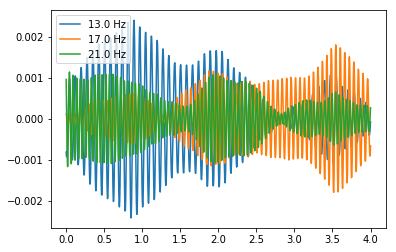

In [15]:
n_seconds = 4
tr = 0
time = linspace(0, n_seconds, n_seconds * sample_rate)
plt.figure()
_ = plt.plot(time.T, trials[tr, 0, :].T, label=str(frequencies[0])+' Hz')
_ = plt.plot(time.T, trials[tr, 8, :].T, label=str(frequencies[1])+' Hz')
_ = plt.plot(time.T, trials[tr, 16, :].T, label=str(frequencies[2])+' Hz')
_ = plt.legend(loc='upper left')
print(labels[tr])

As it can be seen on this example, the subject is watching the 17Hz stimulation and the EEG activity is showing an increase activity in this frequency band as the focus is more and more focus on the blinking stimulation.

### Spatial covariance estimation

The covariance matrices will be estimated using the Schafer shrinkage instead of Ledoit-Wolf shrinkage estimator.  
*** Note: ***  
The Schafer estimation was added to our local copy of pyRiemann

In [16]:
cov_trials = Covariances(estimator='shaf').transform(trials)

Capture process in a function:

In [17]:
def get_session_cavmat(signal, positions, types):
    labels = list()
    for e in types:
        if e == 33024: labels.append('Resting')
        elif e == 33025: labels.append('13Hz')
        elif e == 33026: labels.append('21Hz')
        elif e == 33027: labels.append('17Hz')
    labels = array(labels)  
    # Construct the extended signal
    frequencies = [13., 17., 21.]
    filter_coef = [{'a':[1.0,-1.883459171625896,0.983572253981791],'b':[0.008213873009104,0,-0.008213873009104]}, 
                   {'a':[1.0,-1.812573732694827,0.982661267813152],'b':[0.008669366093424,0,-0.008669366093424]}, 
                   {'a':[1.0,-1.725001953692769,0.982556658907297],'b':[0.008721670546351,0,-0.008721670546351]}]
    ext_signal = empty_like(signal[0,:])    
    for f, coef in zip(frequencies, filter_coef):
        freq_band = 0.05 if f==13 else 0.1
        ext_signal = vstack((ext_signal, butter_bandpass(signal, lowcut=f-freq_band, 
                                                         highcut=f+freq_band, fs=256, a=coef['a'], b=coef['b'])))
    ext_signal = ext_signal[1:,:]
    trials = get_trials(ext_signal, typ=types, pos=positions, tlen=4, offset=2, fs=256)
    cov_trials = Covariances(estimator='shaf').transform(trials)
    return (cov_trials, labels)

## Load covariance matrices from Matlab
Load the covariance matrices from signal processing done in Matlab

In [18]:
data_matlab = pickle.load(open("../data/pycov.pickle",'rb'), encoding='latin1')

In [19]:
data_matlab.keys()

dict_keys(['tangents', 'labels', 'sessions', 'covmats', 'means'])

In [20]:
cov_matlab = data_matlab['covmats']
sess_matlab = data_matlab['sessions']
lab_matlab = data_matlab['labels']
sess_trials_matlab = sess_matlab[subject_test-1]
cov_trials_matlab = cov_matlab[subject_test-1][sess_trials_matlab==session,:,:]
lab_trials_matlab = lab_matlab[subject_test-1][sess_trials_matlab==session]

In [21]:
print('size of matrices: matlab->{}, python->{}'.format(cov_trials_matlab.shape, cov_trials.shape)) 

size of matrices: matlab->(32, 24, 24), python->(32, 24, 24)


In [22]:
labels_matlab = list()
for e in lab_trials_matlab:
    if e == 0: labels_matlab.append('Resting')
    elif e == 1: labels_matlab.append('13Hz')
    elif e == 2: labels_matlab.append('21Hz')
    elif e == 3: labels_matlab.append('17Hz')
labels_matlab = array(labels_matlab)

## Visualize a covariace matrix for each class Python vs Matlab

In [23]:
Covmat = {'python':cov_trials, 'matlab':cov_trials_matlab}
Labels = {'python': labels, 'matlab': labels_matlab}

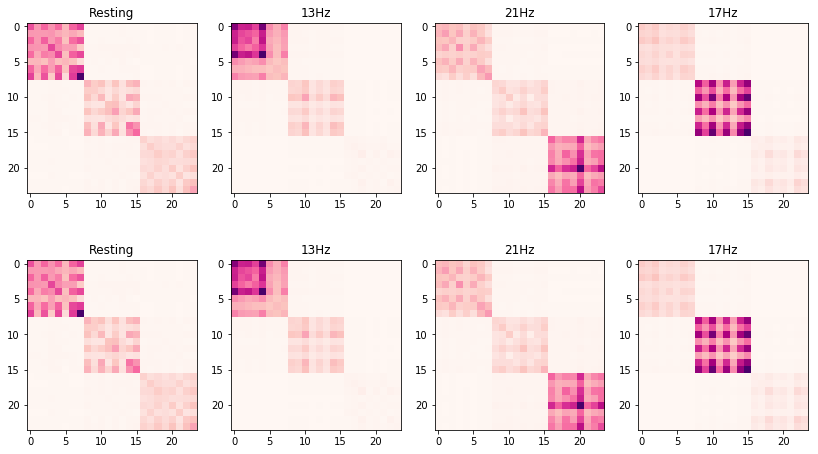

In [24]:
plt.figure(figsize=(14, 8))
place = 1
tr = 4
for tool in ['python', 'matlab']:
    for l in classes:
        plt.subplot(2, 4, place)
        plt.imshow(Covmat[tool][Labels[tool] == l, :, :][tr, :, :], cmap=plt.get_cmap('RdPu'), interpolation='nearest')
        _ = plt.title(l)
        place += 1

Top row: Python processing. Bottom row: Matlab processing

## Get the sum of distance between trials of the same class

In [25]:
intraclass_distance = {'python':0, 'matlab':0}
for tool in ['python', 'matlab']:
    intraclass_distance[tool] = 0
    for cl in classes:
        for tr_i in range(0,8):
            for tr_j in range(tr_i,8):
                intraclass_distance[tool] += distance.distance_riemann(Covmat[tool][Labels[tool] == cl,:,:][tr_i,:,:], Covmat[tool][Labels[tool] == cl,:,:][tr_j,:,:])

In [26]:
print("intraclass distances: Python --> {}, Matlab --> {}".format(intraclass_distance['python'], intraclass_distance['matlab']))

intraclass distances: Python --> 926.6354331304565, Matlab --> 926.6373548407973


## Distance between class means 

In [27]:
# Get means of all classes
Means = defaultdict(defaultdict);
for tool in ['python', 'matlab']:
    for cl in classes:
        Means[tool][cl] = mean.mean_riemann(Covmat[tool][Labels[tool]==cl,:,:])

### Get distances between class means
Show interclass distances in a matrix, for python, then for matlab

In [28]:
intratool_distance = defaultdict(lambda: np.zeros((len(classes),len(classes))))
for tool in ['python', 'matlab']:
    for i, cl_i in enumerate(classes):
        for j, cl_j in enumerate(classes):
            intratool_distance[tool][i,j] = distance.distance_riemann(Means[tool][cl_i],
                                                                     Means[tool][cl_j])

In [29]:
print(intratool_distance['python'])

[[  2.42692315e-14   4.72952032e+00   4.42775569e+00   4.62765406e+00]
 [  4.72952032e+00   3.14540114e-14   5.56644858e+00   5.60368911e+00]
 [  4.42775569e+00   5.56644858e+00   4.42596226e-14   5.25338183e+00]
 [  4.62765406e+00   5.60368911e+00   5.25338183e+00   8.15725365e-14]]


In [30]:
print(intratool_distance['matlab'])

[[  2.29609582e-14   4.72951982e+00   4.42775496e+00   4.62765304e+00]
 [  4.72951982e+00   2.71473935e-14   5.56644869e+00   5.60368883e+00]
 [  4.42775496e+00   5.56644869e+00   3.90686520e-14   5.25338159e+00]
 [  4.62765304e+00   5.60368883e+00   5.25338159e+00   9.55490599e-14]]


### Get distance between python and matlab means of same class

In [31]:
inter_tool_inter_class = list()
for cl in classes:
    inter_tool_inter_class.append(distance.distance_riemann(Means['python'][cl], Means['matlab'][cl]))
    

In [32]:
print(inter_tool_inter_class)

[2.2961416538611336e-06, 3.9684676241571005e-06, 3.3049313792470667e-06, 4.4959986019448044e-06]


## Compare classification performance
Compare MDM performance using AIR

In [33]:
# Reaoder python matrix and labels as Matlab
tmp = Labels['python'].copy()
Covmat['python'] = Covmat['python'][np.concatenate((np.where(tmp=='Resting')[0],np.where(tmp=='13Hz')[0],np.where(tmp=='21Hz')[0],np.where(tmp=='17Hz')[0])),:,:]
Labels['python'] = Labels['python'][np.concatenate((np.where(tmp=='Resting')[0],np.where(tmp=='13Hz')[0],np.where(tmp=='21Hz')[0],np.where(tmp=='17Hz')[0]))]

In [34]:
accuracy = defaultdict()
mdm = classification.MDM()
for tool in ['python', 'matlab']:
    accuracy[tool] = cross_val_score(mdm, Covmat[tool], Labels[tool], cv=4)
    print('{} mean accuracy: {}'.format(tool, accuracy[tool].mean()))

python mean accuracy: 0.90625
matlab mean accuracy: 0.90625


In [35]:
accuracy['matlab']

array([ 0.75 ,  0.875,  1.   ,  1.   ])

In [36]:
accuracy['python']

array([ 0.75 ,  0.875,  1.   ,  1.   ])

# Classification performance on entire data set

In [37]:
accuracy_full_set = defaultdict(lambda: list())

## Python

In [38]:
for subject in range(1,13):
# for subject in [7]:
    raw_signal, event_type, event_pos = get_pickle_data(subject=subject, path='../data/dataset-ssvep-exoskeleton/')
    nb_sess = len(raw_signal)
    labels_list = list()
    cov_list = list()
    for session in range(nb_sess):
        cov_trials, labels = get_session_cavmat(signal=raw_signal[session], positions=event_pos[session], types=event_type[session])
        # Reaoder python matrix and labels as in Matlab data
        tmp = labels.copy()
        cov_trials = cov_trials[np.concatenate((np.where(tmp=='Resting')[0],np.where(tmp=='13Hz')[0],np.where(tmp=='21Hz')[0],np.where(tmp=='17Hz')[0])),:,:]
        labels = labels[np.concatenate((np.where(tmp=='Resting')[0],np.where(tmp=='13Hz')[0],np.where(tmp=='21Hz')[0],np.where(tmp=='17Hz')[0]))]
        cov_list.append(cov_trials)
        labels_list.append(labels)
    covpy = np.concatenate(cov_list,axis=0)
    labpy = np.concatenate(labels_list)
    mdm = classification.MDM()
    accuracy = cross_val_score(mdm, covpy, labpy, n_jobs=-1,
                               groups=np.repeat(np.linspace(0,nb_sess-1,nb_sess),32), cv=nb_sess)
    # accuracy = cross_val_score(mdm, covpy, labpy, cv=nb_sess)
    print('Subject {}: {}'.format(subject, accuracy.mean()))
    accuracy_full_set['python'].append(accuracy)

Subject 1: 0.734375
Subject 2: 0.796875
Subject 3: 0.859375
Subject 4: 0.875
Subject 5: 0.6875
Subject 6: 0.859375
Subject 7: 0.8854166666666666
Subject 8: 0.8645833333333334
Subject 9: 0.703125
Subject 10: 0.7291666666666666
Subject 11: 0.6015625
Subject 12: 0.96875


## Matlab

In [39]:
cov_matlab = data_matlab['covmats']
sess_matlab = data_matlab['sessions']
lab_matlab = data_matlab['labels']
for subject in range(1,13):
# for subject in [7]:
    sess_trials_matlab = sess_matlab[subject-1]
    covmatlab = cov_matlab[subject-1]
    lab_trials_matlab = lab_matlab[subject-1]
    labels_matlab = list()
    for e in lab_trials_matlab:
        if e == 0: labels_matlab.append('Resting')
        elif e == 1: labels_matlab.append('13Hz')
        elif e == 2: labels_matlab.append('21Hz')
        elif e == 3: labels_matlab.append('17Hz')
    labmatlab = array(labels_matlab)
    mdm = classification.MDM()
    accuracy = cross_val_score(mdm, covmatlab, labmatlab, 
                               groups=sess_trials_matlab, cv=len(np.unique(sess_trials_matlab)))
    # accuracy = cross_val_score(mdm, covmatlab, labmatlab, cv=nb_sess)
    print('Subject {}: {}'.format(subject, accuracy.mean()))
    accuracy_full_set['matlab'].append(accuracy)

Subject 1: 0.734375
Subject 2: 0.796875
Subject 3: 0.859375
Subject 4: 0.875
Subject 5: 0.6875
Subject 6: 0.859375
Subject 7: 0.8854166666666666
Subject 8: 0.921875
Subject 9: 0.703125
Subject 10: 0.8046875
Subject 11: 0.65625
Subject 12: 0.96875


In [40]:
accuracy_full_set['python']

[array([ 0.8125 ,  0.65625]),
 array([ 0.78125,  0.8125 ]),
 array([ 0.90625,  0.8125 ]),
 array([ 0.84375,  0.90625]),
 array([ 0.71875,  0.65625]),
 array([ 0.84375,  0.875  ]),
 array([ 0.90625,  0.90625,  0.84375]),
 array([ 0.6875 ,  0.90625,  1.     ]),
 array([ 0.6875 ,  0.71875]),
 array([ 0.4375 ,  0.875  ,  0.8125 ,  0.84375,  0.75   ,  0.65625]),
 array([ 0.6875 ,  0.34375,  0.6875 ,  0.6875 ]),
 array([ 0.96875,  0.96875,  0.96875,  0.96875,  0.96875])]

In [41]:
accuracy_full_set['matlab']

[array([ 0.8125 ,  0.65625]),
 array([ 0.78125,  0.8125 ]),
 array([ 0.90625,  0.8125 ]),
 array([ 0.84375,  0.90625]),
 array([ 0.71875,  0.65625]),
 array([ 0.84375,  0.875  ]),
 array([ 0.90625,  0.90625,  0.84375]),
 array([ 0.875  ,  0.96875]),
 array([ 0.6875 ,  0.71875]),
 array([ 0.90625,  0.84375,  0.78125,  0.6875 ]),
 array([ 0.625 ,  0.6875]),
 array([ 0.96875,  0.96875,  0.96875,  0.96875,  0.96875])]

**Remarks**    
Subjects 8, 10, and 11 do not have the same number of sessions!